In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import sympy as sp
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly import tools

train_data = pd.read_csv('L:/AA_NUS/dsa5101/traininingdata.txt', sep=";")
test_data = pd.read_csv('L:/AA_NUS/dsa5101/testdata.txt', sep=";")

In [59]:
##pre-processing
def age(df):
    bins = pd.cut(df["age"], [17, 30, 40, 55, 100]) # 划分薪资档次
    df["age_class"] = bins
    df[["age_class"]] = df[["age_class"]].astype("str") # 转化为字符串类型
    df.replace({'age_class': {"(17, 30]":'0', "(30, 40]":'1', "(40, 55]":'2', "(55, 100]":'3'}}, inplace=True) 
    return df
train_data = age(train_data)
test_data = age(test_data)
train_data.groupby('age')['job'].count()

# yes-no->1-0
def zero_one(df):
    df["default"] = df["default"].apply(lambda x: 1 if x=='yes' else 0)
    df["housing"] = df["housing"].apply(lambda x: 1 if x=='yes' else 0)
    df["loan"] = df["loan"].apply(lambda x: 1 if x=='yes' else 0)
    df["y"] = df["y"].apply(lambda x: 1 if x=='yes' else 0)
    return df
train_data = zero_one(train_data)
test_data = zero_one(test_data)
y = train_data['y']
test_y = test_data['y']

#col_list
col_list=["age","job","marital","education","default","balance","housing","loan","contact","duration","campaign","pdays","previous","poutcome","y"]
col_unknown = ['job','education','contact','poutcome']
col_known = list(set(col_list) - set(col_unknown)-set(['y']))

# 对分类变量进行onehot编码, 并用决策树对unknown值进行填补
# def onehot_unknown(train_data):
#     data_complete = pd.get_dummies(train_data[col_known], drop_first = True)
#     data_incomplete = train_data[col_unknown]
#     for i in range(len(col_unknown)):
#         index_imcomplete = train_data[train_data[col_unknown[i]] == 'unknown'].index
#         index_complete = train_data[train_data[col_unknown[i]] != 'unknown'].index
#         clf = DecisionTreeClassifier()
#         clf.fit(data_complete.iloc[index_complete], data_incomplete.iloc[index_complete,i])
#         missing_values = data_complete.iloc[index_imcomplete]
#         predicted_values = clf.predict(missing_values)
#         # 更新原始数据框中的缺失值
#         data_incomplete.iloc[index_imcomplete, i] = predicted_values
#     data_incomplete = pd.get_dummies(data_incomplete, drop_first = True)
#     df = pd.concat([data_complete,data_incomplete],axis=1)
#     return df              
# train_data = onehot_unknown(train_data)
# test_data = onehot_unknown(test_data)
                                     

In [57]:
train_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_class
0,42,technician,divorced,secondary,0,-78,0,0,cellular,29,jul,10,23,-1,0,unknown,0,2
1,50,management,married,tertiary,0,106,0,0,unknown,15,may,388,2,-1,0,unknown,0,2
2,47,admin.,married,secondary,0,407,0,0,unknown,5,jun,67,12,-1,0,unknown,0,2
3,39,admin.,divorced,secondary,0,952,0,0,unknown,16,jun,62,1,-1,0,unknown,0,1
4,30,management,single,tertiary,0,364,0,0,cellular,30,apr,306,2,-1,0,unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,30,management,single,tertiary,0,1243,0,0,telephone,13,nov,86,1,174,1,failure,0,0
36164,60,blue-collar,married,secondary,0,171,0,0,unknown,19,may,219,2,-1,0,unknown,0,3
36165,41,technician,married,secondary,0,-274,0,0,unknown,27,may,182,3,-1,0,unknown,0,2
36166,45,blue-collar,married,primary,0,103,0,0,cellular,28,jan,64,3,-1,0,unknown,0,2


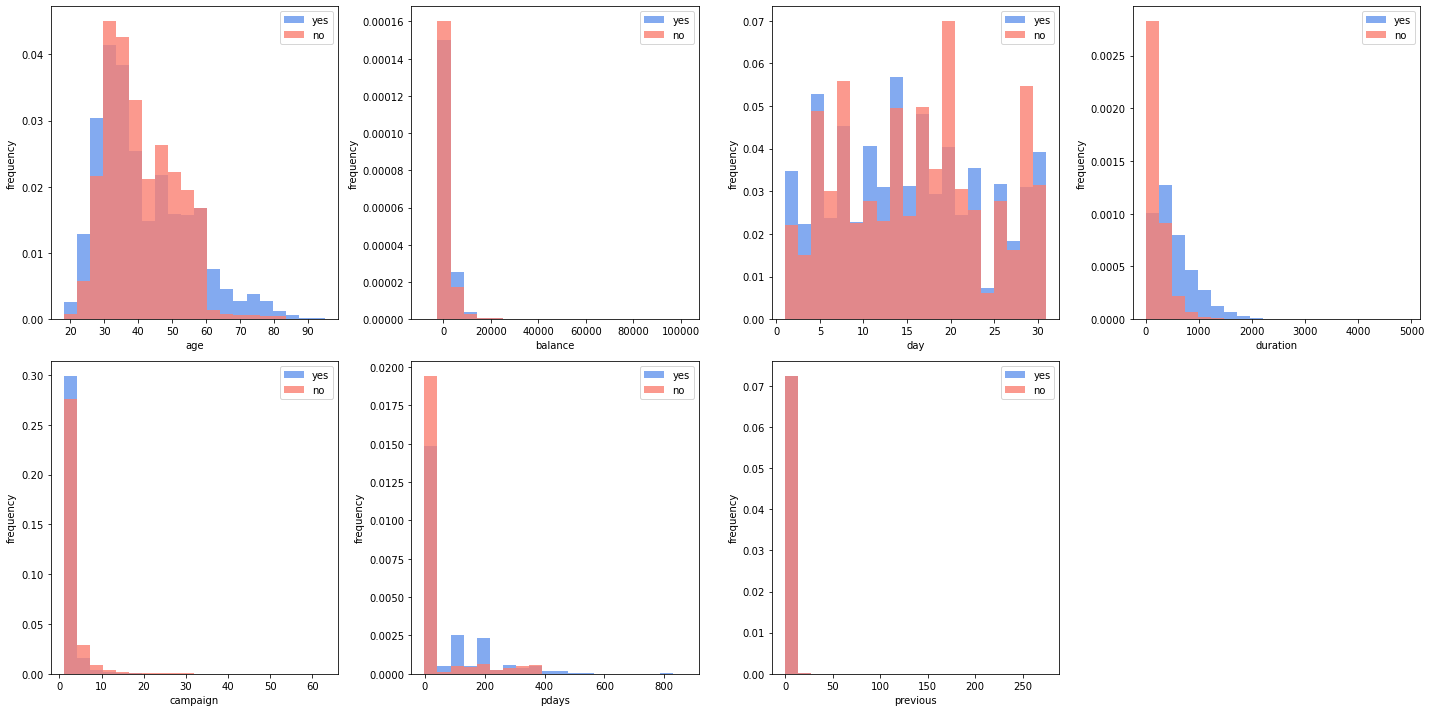

In [63]:
##histgram for numeric features (hue: y)
col_list=["age","job","marital","education","default","balance","housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome","y"]
col_numeric = ["age","balance","day","duration","campaign","pdays","previous"]
col_class = list(set(col_list) - set(col_numeric) -set(['y']))
plt.figure(figsize=(20,10))
for i in range(len(col_numeric)):
    
    plt.subplot(2,4,i+1)
    plt.hist(train_data[train_data['y']==1][col_numeric[i]],color='cornflowerblue',density=True,alpha=0.8,bins=20,range = (train_data[col_numeric[i]].min(),train_data[col_numeric[i]].max()))
    plt.hist(train_data[train_data['y']==0][col_numeric[i]],color='salmon',density=True,alpha=0.8,bins=20,range = (train_data[col_numeric[i]].min(),train_data[col_numeric[i]].max()))
    plt.xlabel(col_numeric[i])
    plt.ylabel('frequency')
    plt.legend(['yes','no'])
    
plt.tight_layout(pad=1.08)
plt.show()

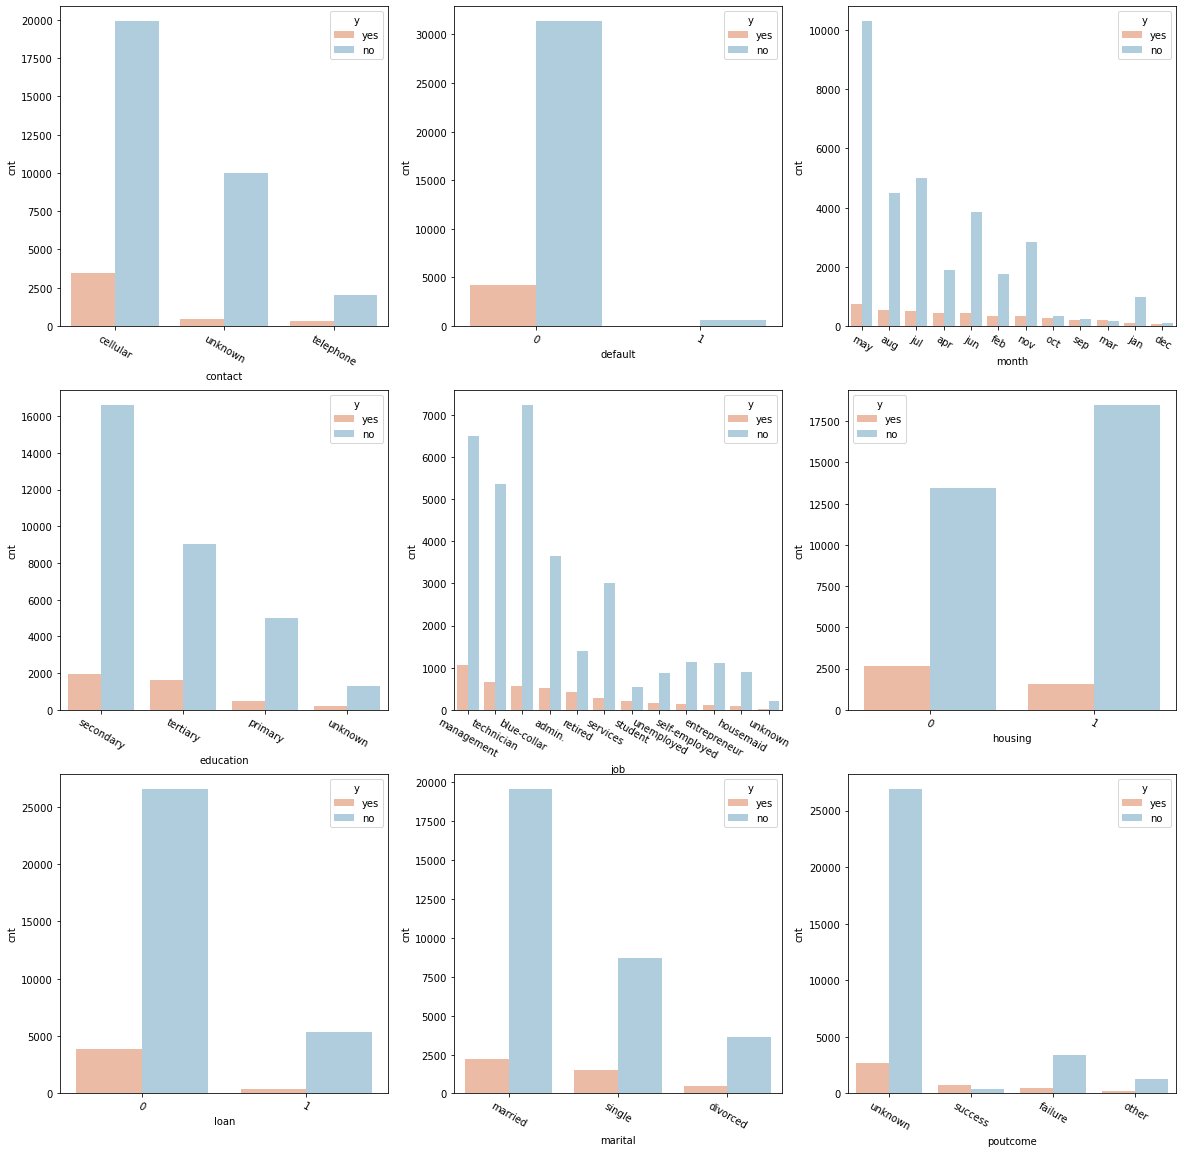

In [62]:
##histgram for non-numeric features(by amount) (hue: y)
plt.figure(figsize=(20,20))
m=len(col_class)
for j in range(m):
    col = col_class[j]
    val1 = pd.DataFrame(train_data[train_data['y']==1][col].value_counts()) 
    col_v = pd.DataFrame(val1.index)
    val1.index = list(range(len(val1)))
    val1 = pd.concat([val1,pd.DataFrame(['yes']*len(val1.index)),col_v],axis=1)

    val2 = pd.DataFrame(train_data[train_data['y']==0][col].value_counts()) 
    col_v = pd.DataFrame(val2.index)
    val2.index = list(range(len(val2)))
    val2 = pd.concat([val2,pd.DataFrame(['no']*len(val1.index)),col_v],axis=1)

    val = pd.concat([val1,val2],axis=0)
    val.columns = ['cnt','y',col]
    
    plt.subplot(3,3,j+1)
    sns.barplot(data=val, x=col, y="cnt", hue="y", palette="RdBu")
    plt.xticks(rotation=-30)


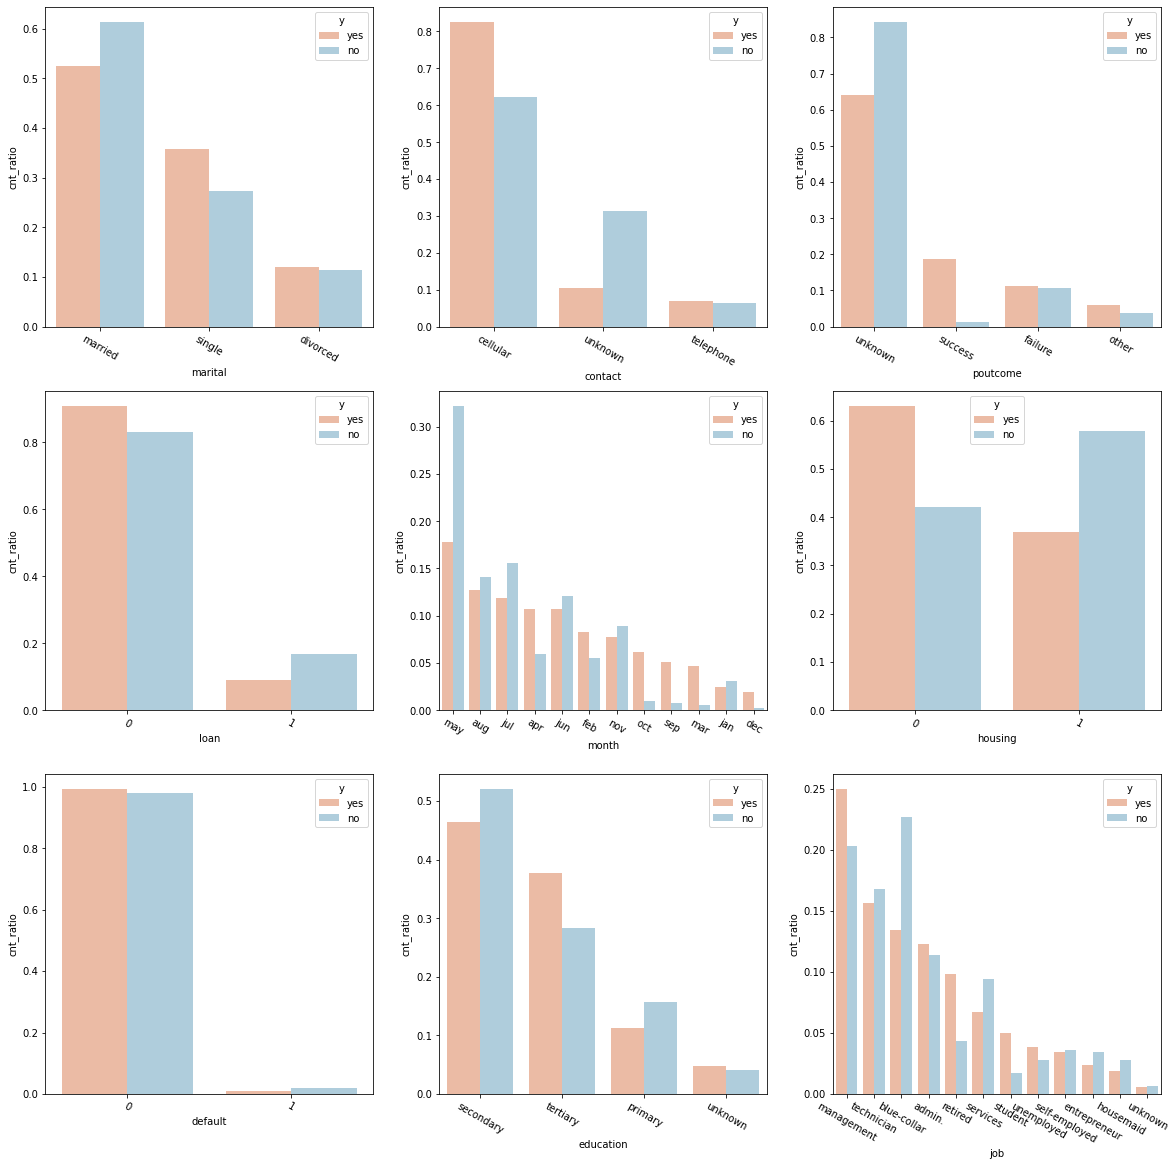

In [18]:
##histgram for non-numeric features(by density) (hue: y)
plt.figure(figsize=(20,20))
m=len(col_class)
n1 = len(train_data[train_data['y']==1])
n2 = len(train_data[train_data['y']==0])
for j in range(m):
    col = col_class[j]
    val1 = pd.DataFrame(train_data[train_data['y']==1][col].value_counts()/n1) 
    col_v = pd.DataFrame(val1.index)
    val1.index = list(range(len(val1)))
    val1 = pd.concat([val1,pd.DataFrame(['yes']*len(val1.index)),col_v],axis=1)

    val2 = pd.DataFrame(train_data[train_data['y']==0][col].value_counts()/n2) 
    col_v = pd.DataFrame(val2.index)
    val2.index = list(range(len(val2)))
    val2 = pd.concat([val2,pd.DataFrame(['no']*len(val1.index)),col_v],axis=1)

    val = pd.concat([val1,val2],axis=0)
    val.columns = ['cnt_ratio','y',col]
    
    plt.subplot(3,3,j+1)
    sns.barplot(data=val, x=col, y="cnt_ratio", hue="y", palette="RdBu")
    plt.xticks(rotation=-30)


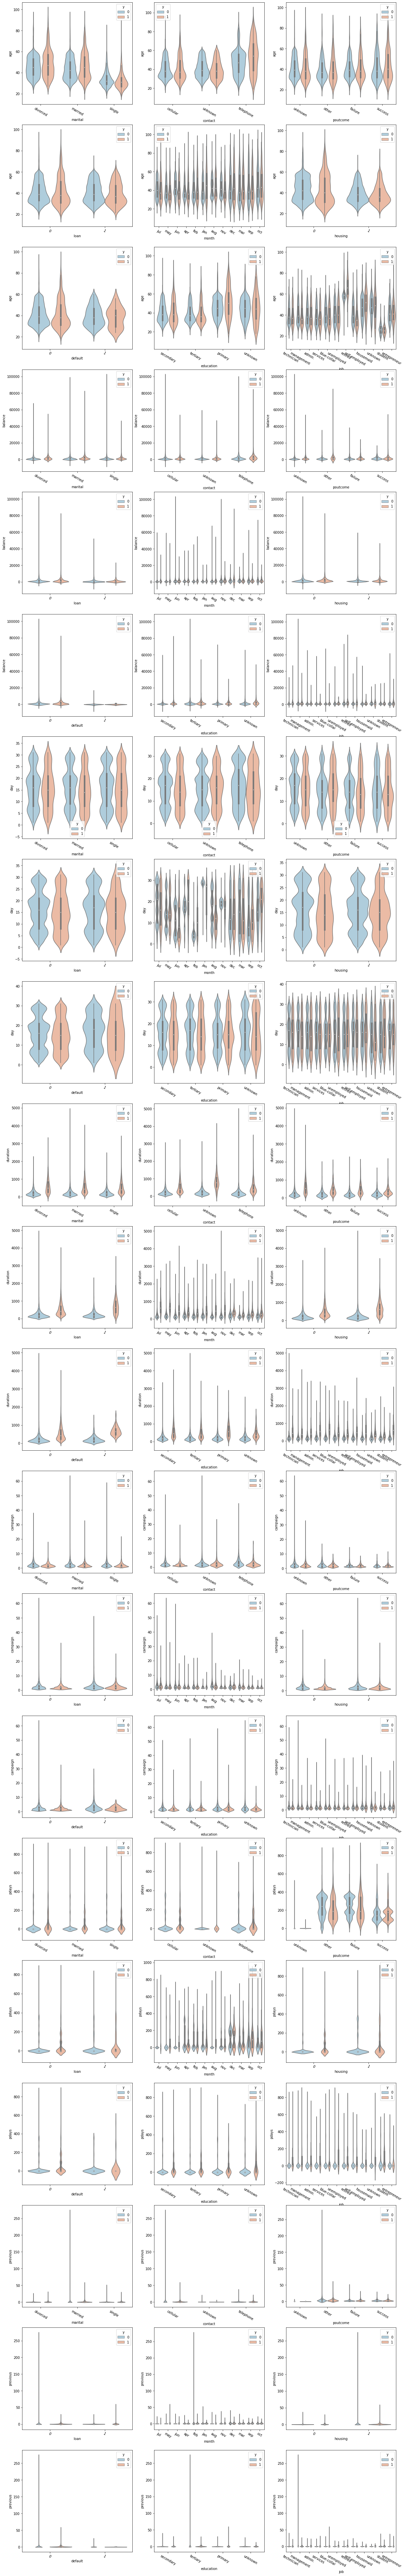

In [19]:
# violinplot for numeric and non-numeric columns 
plt.figure(figsize=(20,140))
# n=7 m=9
n,m=len(col_numeric),len(col_class)
for i in range(n):
    for j in range(m):
        plt.subplot(n*3,int(m/3),i*m+j+1)
        sns.violinplot(x=col_class[j], y=col_numeric[i], hue="y",
                    data=train_data, palette="RdBu_r")
        plt.xticks(rotation=-30)
        
plt.show()

<AxesSubplot:>

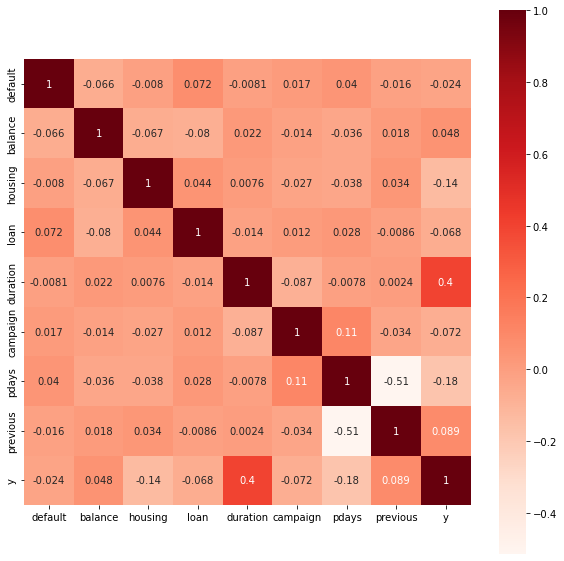

In [42]:
##heatmap for numeric cols 
d_cor = train_data.corr()
plt.subplots(figsize = (10,10))
sns.heatmap(d_cor,annot = True,vmax = 1,square = True,cmap = "Reds")

In [51]:
#balance bar_polar plot by balance_status and job
df = train_data.copy()
df["balance_status"] = np.nan
lst = [df]

for col in lst:
    col.loc[col["balance"] < 0, "balance_status"] = "negative"
    col.loc[(col["balance"] >= 0) & (col["balance"] <= 40000), "balance_status"] = "low"
    col.loc[(col["balance"] > 40000) & (col["balance"] <= 50000), "balance_status"] = "middle"
    col.loc[col["balance"] > 50000, "balance_status"] = "high"
    
# balance by balance_status
negative = df["balance"].loc[df["balance_status"] == "negative"].values.tolist()
low = df["balance"].loc[df["balance_status"] == "low"].values.tolist()
middle = df["balance"].loc[df["balance_status"] == "middle"].values.tolist()
high = df["balance"].loc[df["balance_status"] == "high"].values.tolist()


# Get the average by occupation in each balance category
job_balance = df.groupby(['job', 'balance_status'])['balance'].mean()
# aaa = pd.DataFrame(job_balance)
# aaa.to_excel('./group_by.xlsx')
gbp_data = pd.read_excel('./group_by.xlsx')
#gbp_data['age_class']=gbp_data['age_class'].astype("str")
#gbp_data['balance'] = gbp_data['balance']+415
gbp_data.replace({'balance_status': {"negative":'0_negative', "low":'1_low', "middle":'2_middle', "high":'3_high'}}, inplace=True) 
gbp_data = gbp_data.sort_values(by=['balance_status'], ascending=True)
fig = px.bar_polar(gbp_data, r="balance", theta="job",
                   color="balance_status", 
                   color_discrete_sequence= px.colors.sequential.Blugrn)
fig.show()

In [64]:
#balance bar_polar plot by balance_status and age_class
job_balance = df.groupby(['age_class', 'balance_status'])['balance'].mean()
# aaa = pd.DataFrame(job_balance)
# aaa.to_excel('./group_by2.xlsx')
gbp_data = pd.read_excel('./group_by2.xlsx')
gbp_data.replace({'balance_status': {"negative":'0_negative', "low":'1_low', "middle":'2_middle', "high":'3_high'}}, inplace=True) 
gbp_data = gbp_data.sort_values(by=['balance_status'], ascending=True)
gbp_data['age_class']=gbp_data['age_class'].astype("str")
fig = px.bar_polar(gbp_data, r="balance", theta="age_class",
                   color="balance_status", 
                   color_discrete_sequence= px.colors.sequential.Blugrn)
fig.show()

In [53]:
#balance bar_polar plot by balance_status and education
job_balance = df.groupby(['education', 'balance_status'])['balance'].mean()
# aaa = pd.DataFrame(job_balance)
# aaa.to_excel('./group_by3.xlsx')
gbp_data = pd.read_excel('./group_by3.xlsx')
gbp_data.sort_values(by=['balance_status'])
gbp_data.replace({'balance_status': {"negative":'0_negative', "low":'1_low', "middle":'2_middle', "high":'3_high'}}, inplace=True) 
gbp_data = gbp_data.sort_values(by=['balance_status'], ascending=True)
fig = px.bar_polar(gbp_data, r="balance", theta="education",
                   color="balance_status", range_r = [gbp_data['balance'].min(),gbp_data['balance'].max()],barmode='relative',
                   color_discrete_sequence= px.colors.sequential.Blugrn)
fig.show()

In [68]:
# histogram(density) for balance by marital
single = df['balance'].loc[df['marital'] == 'single'].values
married = df['balance'].loc[df['marital'] == 'married'].values
divorced = df['balance'].loc[df['marital'] == 'divorced'].values


single_dist = go.Histogram(
    x=single,
    histnorm='probability', 
    name='single',
    marker=dict(
        color='#6E6E6E'
    )
)


married_dist = go.Histogram(
    x=married,
    histnorm='probability', 
    name='married',
    marker=dict(
        color='#2E9AFE'
    )
)

divorced_dist = go.Histogram(
    x=divorced,
    histnorm='probability', 
    name='divorced',
    marker=dict(
        color='#FA5858'
    )
)


fig = tools.make_subplots(rows=3, print_grid=False)

fig.append_trace(single_dist, 1, 1)
fig.append_trace(married_dist, 2, 1)
fig.append_trace(divorced_dist, 3, 1)


fig['layout'].update(showlegend=False, title="Balance Distributions by Marital Status",
                    height=1000, width=800)

iplot(fig, filename='custom-sized-subplot-with-subplot-titles')